In [2]:
import numpy as np
import re
import matplotlib.pyplot as plt
import os
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
%matplotlib inline

In [3]:
# Constants
RCATH=0.002            # Cathode radius [m]
RTUBE=0.05             # Tube radius [m]
ECOOL=583              # uncorrected cooling energy [eV] from RR symmetrization, set value: 582.98
ECUR=0.01947           # Electron current [A] #!!!!!!!!!!!!!!! zmiana
EXP=33                 # Adiabatic beam expansion factor
MASS_ION= 14896453700  #14896453700   # ion mass [eV/c²] -> oxygen BUT! find better
#MASS_ION_AMU=0.1797    # ion mass [amu] -> neon ??????? 20?
ETA=0.020303           # COOL_LENGTH/CIRC
COOL_LENGTH=1.1        # Cooler interaction zone length [m]; assume error of 1 cm
CIRC=54.178            # Ring orbit [m]; error ca. 12.5 cm assuming the orbit might be 2 cm further out or in
F_REV =253626          # revolution frequency [Hz]

#determine/estimate appropriate error values
RCATH_ERROR=0.0002   #10%
RTUBE_ERROR=0.0001   #1/10 of a mm machining tolerance
ECOOL_ERROR=1.0      #based on RR symmetrization
ECUR_ERROR=0.0002    #10%
EXP_ERROR=0.1        #no idea
ETA_ERROR=0.00023    #see assumptions for COOL_LENGTH and CIRC above
F_REV_ERROR=2500

# Fundamental constants. 
PI=3.14159265358979312
C_LIGHT=299792458              # Speed of light [m/s]
ELEM_CHARGE=1.60217653e-19     # Elementary charge [C]
AMU=931.494102e6               # eV
AMU_KG=1.66053886e-27          # Atomic mass [kg]
MASS_E=510998.950              # Electron mass [eV x c²], CODATA2018
MASS_E_KG=9.1093826e-31        # Electron mass [kg]
BOLTZMANN=8.617343e-5          # [eV/K]
BOLTZMANN_J=BOLTZMANN*ELEM_CHARGE              # [J/K]
ALPHA=7.297352568e-3            # ~1/137
G_E=2.0231930436                # g-Factor electron (CODATA)
EPSILON_0=8.854187817e-12       # C/Vm
MU_0=4.*PI*1e-7                 # permeability of free space, (N*A^2) SI units.
RYDBERG_CONST=13.6056923        # eV
epsilon=1e-15;

# CryringData Class 

Here is a class for Oxygen data analysis 

In [48]:
class CryringData:
    def __init__(self, filename):
        self.name = filename[7:9]    # Extract the substring containing the desired name
        self.prepare_data(filename)
    
    def prepare_data(self, filename):
        myvars = {}
        with open(filename) as myfile:
            for cnt in range(88):
                line = next(myfile)
                if ':' in line:
                    name, var = line.partition(':')[::2]
                    name = name.strip().strip('#')
                    var = var.strip()
                    myvars[name.strip()] = var                
            header_line = next(myfile)
        
        #Values useful for me from header
        self.e_curr = float(myvars['electron current (mA)'])*0.001
        
        try:
            self.main_pow_supply = float(myvars['cath meas voltage (V)'])
        
        except KeyError:
            self.main_pow_supply = float(myvars['cathode voltage (V)']) 
        
        self.cooling_energy = float(myvars['cooling energy (eV)']) #this is not the best chice- it is a set value- better from shotky
        self.ion_energy = float(myvars['ion energy (MeV/u)'])
        #self.header_keys = myvars.keys()
        #self.header_values = myvars.values()
        
        #Labels give the labels for each array in self.data
        header_line = header_line.strip('#')
        header_line = re.split(r'\[\d+\]', header_line)
        self.labels = header_line
        #Data - without last two columns (there is str "-")
        self.data = np.genfromtxt(filename, delimiter=',',usecols=range(0, 41, 1),dtype=float)
        
    
    def Edensity(self, E):
        """
        Calculates electron density for given energy and current
        based on Esthers work, 
        
        Esther: uses Ecalib_lab line 705
        ecalib_lab = ElabtoEsc(Elabnew);
        ecalib_lab_err = ElabtoEsc_err(Elabnew, Elabnew_err);
        Ecoolsc = ElabtoEsc(ECOOL);
        Ecoolsc_err = ElabtoEsc_err(ECOOL, ECOOL_ERROR);

        ecalib_cm = EsctoEcm(ecalib_lab, Ecoolsc);
        ecalib_cm_err = EsctoEcm_err(ecalib_lab, Ecoolsc, ecalib_lab_err, Ecoolsc_err);
        """
        #gamma = 1 + E / MASS_E
        #beta = np.sqrt(1.0-pow(gamma,-2))
        beta_e = np.sqrt(1.0-pow(1+E/MASS_E,-2))
        dens = self.e_curr / (ELEM_CHARGE * EXP * np.pi * RCATH * RCATH * beta_e * C_LIGHT)
        return dens

    def ElabtoEsc(self, Elab):
        """
        Performs space-charge correction on lab energy values
        Esther
        """
        SC = 0
        Eold, Enew, ne, acc1, acc, eps, factor = 0, 0, 0, 0, 1.0, 0.0000001, 0
        i, maxiter, sign = 0, 100, 0
        factor = ELEM_CHARGE*RCATH*RCATH*EXP/(4*EPSILON_0) * (1 + 2*np.log(RTUBE/(RCATH*np.sqrt(EXP))))
        while np.all(acc > eps) and i < maxiter:
            Eold = Enew
            Enew = Elab - SC
            ne = self.Edensity(Elab)
            SC = ne * factor
            acc1 = Eold / Enew - 1
            sign = np.where(acc1 > 0, 1, -1)
            acc = sign * acc1
            i += 1
        return Enew
    

    def EsctoEcm(self, Esc):
        """
        Performs transformation of (space-charge corrected) lab energy to centre-of-mass energy
        Esther
        """
        Ecool = self.cooling_energy-1.9455 #value was obtained based on the RR peak
        Ei = Ecool * MASS_ION / MASS_E
        sign = np.ones_like(Esc)
        sign[Esc > Ecool] = 1
        sign[Esc <= Ecool] = -1

        aa = MASS_ION + MASS_E
        sqrti = np.sqrt(Ei * (Ei + 2 * MASS_ION))
        sqrte = np.sqrt(Esc * (Esc + 2 * MASS_E))
        bb = Ei * Esc + Ei * MASS_E + Esc * MASS_ION - sqrti * sqrte

        Ec = sign * (np.sqrt(aa*aa + 2 * bb) - aa)
        return Ec
    

    
    def calibrated_LAB(self):
        """
        Performs calibration for energy, for oxygen data collection we had a long jump of main power supply 
        and the arnold values are deformated at begining, moreover they are scaterred (needs to be smoothen-> value)
        """
        if self.name == "01":
            value = 100
        elif self.name == "03": 
            value = 200
        elif self.name == "04": 
            value = 450
        elif self.name == "05": 
            value = 200
        elif self.name == "06": 
            value = 650 #usunac ostatnie dwa punkty?
        elif self.name == "07": 
            value = 400            
        elif self.name == "08": 
            value = 300
        elif self.name == "09": 
            value = 8500
        elif self.name == "10": 
            print("SPARK? wird Arnold behaviour")
        elif self.name == "11": 
            value = 1200
        elif self.name == "12": 
            value = 170 #moze trzeba usunac pierwsze kilka punktow???
        elif self.name == "13": 
            value = 250 #usunac ostatnie :1250
        else: value = 1000
            
       
        if self.main_pow_supply == 5580.5:
            slope = 0.99957
            intercept = 0.74
        elif self.main_pow_supply == 3500:
            slope = 0.99974
            intercept = -0.048
        else:# self.main_pow_supply == 3000:
            slope = 0.99977
            intercept = -0.05
        x = self.data[:,0]
        y = self.data[:,13] #g35
        spl = UnivariateSpline(x, y, s=value)
        y_fit = spl(x)*slope+intercept

        if self.name=="01":
            return (self.EsctoEcm(self.ElabtoEsc(y_fit)))
        else:
            return np.abs(self.EsctoEcm(self.ElabtoEsc(y_fit))) 


    def histogram(self, s=1000):
        hist=[[],[]]
        x = self.calibrated_LAB(s)
        y = self.data[:,7][::-1]
        min_x = np.min(np.abs(x))
        max_x = np.max(np.abs(x))
        range_x = np.abs(max_x-min_x)
        bins_x = np.ceil(range_x/0.1).astype(int)
        print(bins_x)
        hist[1] = np.histogram(x, bins=abs(bins_x), range=(min_x,min_x+(bins_x*0.1)), weights=y)[0]
        hist[0] = np.arange(min_x, min_x+(abs(bins_x)*0.1), 0.1)
        return hist
    
    def compose_data_v1(self, other, s1=1000, s2=1000, b=0.1):
        hist=[[],[]]
        x = np.concatenate((self.calibrated_LAB(s1), other.calibrated_LAB(s2)))
        y = np.concatenate((self.data[:,7], other.data[:,7]))
        print(len(y),len(x))
        min_x = np.min(np.abs(x))
        max_x = np.max(np.abs(x))
        range_x = np.abs(max_x-min_x)
        bins_x = np.floor(range_x/b).astype(int)
        hist[1] = np.histogram(x, bins=bins_x, range=(min_x,min_x+(bins_x*b)), weights=y)[0]
        hist[0] = np.arange(min_x, min_x+(bins_x*b), b)
        return hist
    
    ## histogram and analyse the background

    #add histograms
    
    #np.histogram





In [49]:
data01 = CryringData('06ramp001.yrdr')
data03 = CryringData('06ramp003.yrdr')
data04 = CryringData('06ramp004.yrdr')
data05 = CryringData('06ramp005.yrdr')
data06 = CryringData('06ramp006.yrdr')
data08 = CryringData('06ramp008.yrdr')
data07 = CryringData('06ramp007.yrdr')
data09 = CryringData('06ramp009.yrdr')
data10 = CryringData('06ramp010.yrdr')
data11 = CryringData('06ramp011.yrdr')
data12 = CryringData('06ramp012-Copy1.yrdr')
data13 = CryringData('06ramp013-Copy1.yrdr')


In [50]:
data10.labels[13]

'   HV Arnold 1 meas (V) '

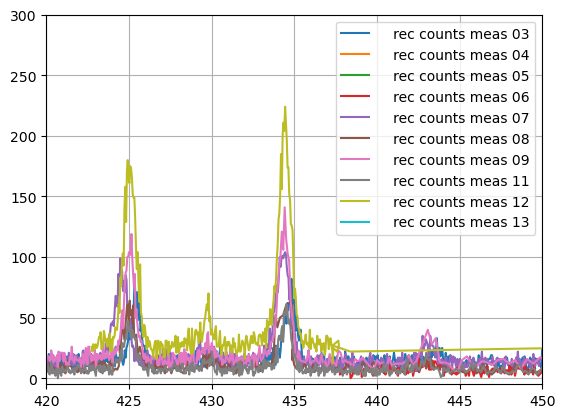

In [54]:
fig = plt.figure()
ax = fig.gca()
ax.plot(data03.calibrated_LAB(), data03.data[:,7], label = data01.labels[7]+"03")
ax.plot(data04.calibrated_LAB(), data04.data[:,7], label = data01.labels[7]+"04")
ax.plot(data05.calibrated_LAB(), data05.data[:,7], label = data01.labels[7]+"05")
ax.plot(data06.calibrated_LAB(), data06.data[:,7], label = data01.labels[7]+"06")
ax.plot(data07.calibrated_LAB(), data07.data[:,7], label = data01.labels[7]+"07")
ax.plot(data08.calibrated_LAB(), data08.data[:,7], label = data01.labels[7]+"08")
ax.plot(data09.calibrated_LAB(), data09.data[:,7], label = data01.labels[7]+"09")
ax.plot(data11.calibrated_LAB(), data11.data[:,7], label = data01.labels[7]+"11")
ax.plot(data12.calibrated_LAB(), data12.data[:,7], label = data01.labels[7]+"12")
ax.plot(data13.calibrated_LAB(), data13.data[:,7], label = data01.labels[7]+"13")
#plt.xlim(540, 580)
plt.xlim(420, 450)
plt.ylim(-5, 300)
plt.grid()
ax.legend()

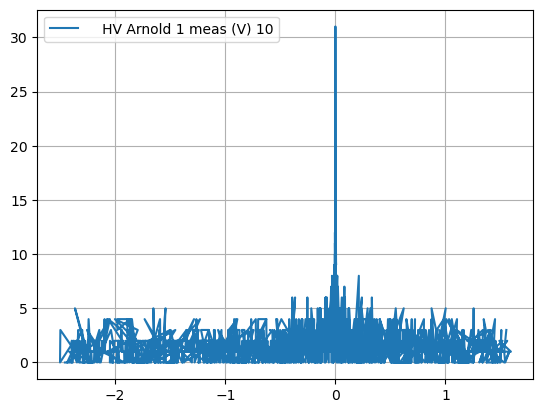

In [52]:
fig = plt.figure()
ax = fig.gca()
#ax.plot(data01.data[:,0],data01.data[:,13],'g-', label = data08.labels[13]+str("10"))
ax.plot(data01.calibrated_LAB(), data01.data[:,7], label = data08.labels[13]+str("10"))

#ax.set_xscale('log')
plt.grid()
ax.legend()

Text(0.5, 0.9, 'Center: -0.00106765')

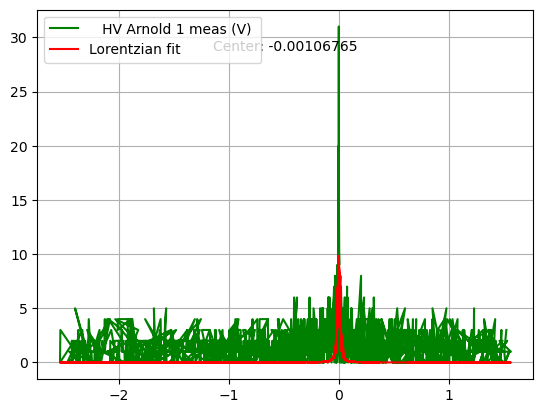

In [47]:
# Define the Lorentzian function
def lorentzian(x, x0, gamma, A):
    return A * (gamma**2) / ((x - x0)**2 + gamma**2)

# Extract the x and y data from your data01 array
x = data01.calibrated_LAB()
y = data01.data[:,7]

# Define the initial parameter values for the fit
x0_init = np.mean(x)
gamma_init = 1.0
A_init = np.max(y)

# Perform the fit using curve_fit
popt, pcov = curve_fit(lorentzian, x, y, p0=[x0_init, gamma_init, A_init])

# Extract the optimal parameter values from the fit
x0_fit, gamma_fit, A_fit = popt

# Plot the original data and the fitted Lorentzian function
fig = plt.figure()
ax = fig.gca()
ax.plot(x, y, 'g-', label=data08.labels[13]+str(""))
ax.plot(x, lorentzian(x, x0_fit, gamma_fit, A_fit), 'r-', label='Lorentzian fit')
plt.grid()
ax.legend()
#ax.set_xscale('log')

# Add a text label to show the center position
ax.text(0.5, 0.9, f'Center: {x0_fit:.8f}', ha='center', va='center', transform=ax.transAxes)

In [46]:
print("Cooling energies for different ramp files \n", 
      "01-", data01.cooling_energy,"\n", "03-", data03.cooling_energy, "\n","04-", data04.cooling_energy,"\n",
     "05-", data05.cooling_energy, "\n", "06-", data06.cooling_energy,"\n", "07-", data07.cooling_energy,"\n",
      "08-", data08.cooling_energy,"\n", "09-", data09.cooling_energy,"\n", "10-", data10.cooling_energy,"\n",
      "11-", data11.cooling_energy,"\n", "12-", data12.cooling_energy, "\n","13-", data13.cooling_energy)

Cooling energies for different ramp files 
 01- 5563.55 
 03- 5563.55 
 04- 5563.55 
 05- 5564.78 
 06- 5564.78 
 07- 5564.78 
 08- 5564.78 
 09- 5564.78 
 10- 5564.78 
 11- 5564.78 
 12- 5564.78 
 13- 5564.78


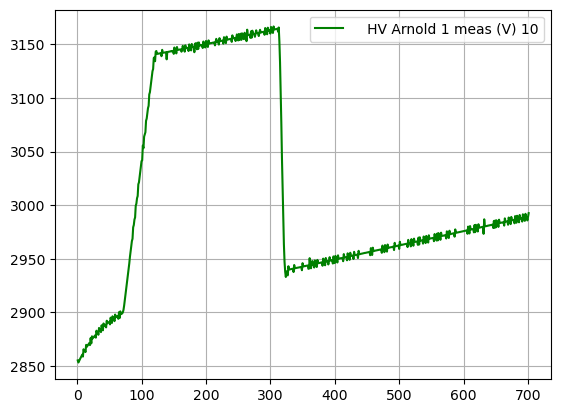

In [10]:
fig = plt.figure()
ax = fig.gca()
#ax.plot(-data08.data[:,3], data08.data[:,7], 'b-', label = data08.labels[7])
#ax.plot(data10.calibrated_LAB(1000), data10.data[:,7], 'b-', label = data08.labels[7]+str("10-calib"))
ax.plot(data10.data[:,0], data10.data[:,13],'g-', label = data08.labels[13]+str("10"))
#ax.plot(data09.compose_data_v1(data08,1000,10000,.1)[:,0], data09.compose_data_v1(data08,1000,10000,.1)[:,1], 'r-', label = "SUM")
#plt.xlim(0,5)
#plt.ylim(2700,2900)
#ax.plot(np.concatenate((data08.calibrated_LAB(), data09.calibrated_LAB(10000))), np.concatenate((data08.data[:,7], data09.data[:,7])) , 'r-', label = "SUM")

plt.grid()
ax.legend()

In [11]:
data08.histogram()

TypeError: calibrated_LAB() takes 1 positional argument but 2 were given

In [ ]:
#data08.compose_data_v1(data09)

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax.plot(data08.calibrated_LAB(), data08.data[:,7], 'b.', label = data08.labels[7])
ax.plot(data09.calibrated_LAB(10000), data09.data[:,7],'g.', label = data08.labels[7])
#ax.plot(data09.compose_data(data08)[:,0], data09.compose_data(data08)[:,1], )
plt.step(data08.compose_data_v1(data09,1000,10000,.1)[0],data08.compose_data_v1(data09,1000,10000,0.1)[1], 'r-', label = "   SUM")
plt.step(data08.compose_data_v1(data09,1000,10000,.2)[0],data08.compose_data_v1(data09,1000,10000,0.2)[1], 'm-', label = "   SUM")
#plt.xlim(440,450)
plt.grid()
ax.legend()

In [ ]:
#data09.compose_data(data08)
x = np.concatenate((data08.calibrated_LAB(), data09.calibrated_LAB()))
y = np.concatenate((data08.data[:,7], data09.data[:,7]))
min_x = 405
max_x = 440
range_x = 35#np.abs(max_x-min_x)
bins_x = 350#np.floor(range_x/0.1)
hist = np.histogram(x, bins=bins_x, range=(min_x,min_x+(bins_x*0.1)))[0]
e_axis = np.arange(min_x, min_x+(bins_x*0.1), 0.1)
#plt.step(e_axis, hist)

In [ ]:
x = data08.calibrated_LAB()
y = data08.data[:,7]
min_x = 405
max_x = 440
range_x = 35#np.abs(max_x-min_x)
bins_x = 350#np.floor(range_x/0.1)
hist = np.histogram(x, bins=bins_x, range=(min_x,min_x+(bins_x*0.1)), weights=y[::-1])[0]
e_axis = np.arange(min_x, min_x+(bins_x*0.1), 0.1)
plt.step(e_axis, hist)


In [ ]:
data06 = CryringData('06ramp006.yrdr')
data06.data

In [ ]:
calib06 = data06.calibrated_LAB()
calib06

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax.plot(calib06, data06.data[:,7], label = data06.labels[7])
plt.grid()
ax.legend()

# RR correction + RR background

In [ ]:
data01 = CryringData('06ramp001.yrdr')

In [ ]:
data01.cooling_energy

In [ ]:
# fig = plt.figure()
# ax = fig.gca()
# #ax.plot(data01.calibrated_LAB(5000), data01.data[:,7], 'r-', label = data01.labels[7])
# ax.plot(data01.data[:,1], data01.data[:,7], label = "set CM energy")
# ax.plot((data01.data[:,1]).ElabtoEsc(), data01.data[:,7], label = "set CM energy")
# plt.grid()
# plt.xscale('log')
# ax.legend()


## Background

In [ ]:
data07 = CryringData('06ramp007.yrdr')

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax.plot(data07.calibrated_LAB(), data07.data[:,7], 'r-', label = data01.labels[7])
ax.plot(data07.calibrated_LAB(), data07.data[:,9], 'b-', label = data01.labels[9])
plt.grid()
ax.legend()

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax.plot(data08.calibrated_LAB(), data08.data[:,7], 'r-', label = data01.labels[7])
ax.plot(data08.calibrated_LAB(), data08.data[:,9], 'b-', label = data01.labels[9])
plt.grid()
ax.legend()

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax.plot(data08.calibrated_LAB(), data08.data[:,7]-data08.data[:,9], 'g-', label = data01.labels[7])
plt.grid()
ax.legend()

# I would like to glue data

## 1. Is there an overlap in lab energy axis? >NO

In [ ]:
calib07 = data07.calibrated_LAB()
calib08 = data08.calibrated_LAB()
calib09 = data09.calibrated_LAB()
calib11 = data11.calibrated_LAB()
calib11

In [ ]:
calib09-calib08

## 2. write compose function

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax.plot(data08.calibrated_LAB(), data08.data[:,7], 'b-', label = data01.labels[7])
ax.plot(data09.calibrated_LAB(10000), data09.data[:,7],'g-', label = data01.labels[7])
#ax.plot(data09.compose_data(data08)[:,0], data09.compose_data(data08)[:,1], 'r-', label = "SUM")

ax.plot(np.concatenate((data08.calibrated_LAB(), data09.calibrated_LAB(10000))), np.concatenate((data08.data[:,7], data09.data[:,7])) , 'r-', label = "SUM")

plt.grid()
ax.legend()

In [ ]:

ddd = np.concatenate((data08.calibrated_LAB(), data09.calibrated_LAB(10000)))

ddd

In [ ]:
hi,hu = np.histogram(ddd, bins=100)


In [ ]:
plt.plot(hi)

In [ ]:
data07.labels[9]

# Junk

In [ ]:
import pandas as pd
#arr = np.vstack((data08.calibrated_LAB(), data08.data[:,7], data08.data[:,9]))
# display the array
#print(arr)
 
# convert array into dataframe
DF = pd.DataFrame((data01.data[:,1], data01.calibrated_LAB(), data01.data[:,7], data01.data[:,8], 
                   data03.calibrated_LAB(), data03.data[:,7], data04.calibrated_LAB(), data04.data[:,7], data05.calibrated_LAB(), data05.data[:,7], data06.calibrated_LAB(), data06.data[:,7], data07.calibrated_LAB(), data07.data[:,7], data07.data[:,9],  data08.calibrated_LAB(), data08.data[:,7], data08.data[:,9], data09.calibrated_LAB(), data09.data[:,7], data11.calibrated_LAB(), data11.data[:,7], data12.calibrated_LAB(), data12.data[:,7], data13.calibrated_LAB(), data13.data[:1250,7]), 
                  index = ["LAB01", "E01", "REC01", "REC_C01", "E03", "REC03", "E04", "REC04", "E05", "REC05", "E06", "REC06", "E07", "REC07", "REF07","E08", "REC08", "REF08","E09", "REC09", "E11", "REC11", "E12", "REC12", "E13", "REC13"])
print(DF.T) 
# save the dataframe as a csv file
DF.T.to_csv("data2.csv")

In [ ]:
        
        if 'cath meas voltage (V)' in myvars:
            self.main_pow_supply = float(myvars['cath meas voltage (V)'])
        else:
            self.main_pow_supply = float(myvars['cathode voltage (V)']) 
          
        


In [ ]:
a = np.array([2,3,3])
b = np.array([4,3,3])

In [ ]:
np.concatenate((a,b))

In [ ]:
np.vstack((a,b))[1]

In [ ]:
np.re


In [ ]:
a=1.3
np.floor(a, dtype=int)


In [ ]:
mean_sim = 400
sigma_sim = 40
data = np.random.normal(loc = mean_sim, scale = sigma_sim, size=10000)
hist = np.histogram(data, bins=350, range=(0,1000))[0]
x = np.arange(400, 455, 0.1)
#plt.step(x, hist)
